In [1]:
from tqdm.notebook import tqdm
import supervision as sv
from ultralytics import YOLO

In [ ]:
# Load model
my_model = "models/best.pt"
their_model = "models/football-player-detection.pt"
model = YOLO(my_model)


0: 736x1280 20 players, 3 referees, 99.2ms
Speed: 9.1ms preprocess, 99.2ms inference, 230.5ms postprocess per image at shape (1, 3, 736, 1280)


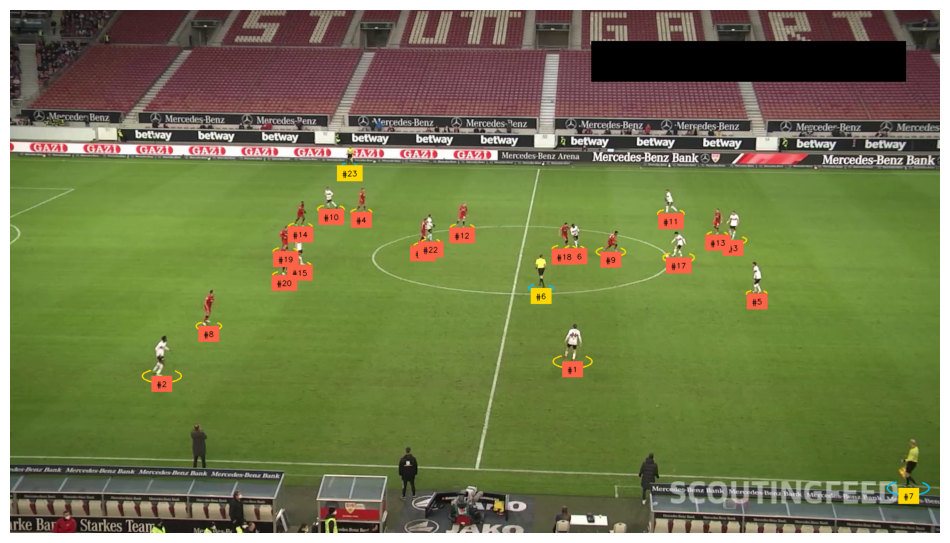

In [3]:
source_video_path = "data/video_0.mp4"
output_video_path = "data/output_video_0.mp4"

COLORS = ['#00BFFF', '#FF6347', '#FFD700']
BALL_ID = 0

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    thickness=2,
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(COLORS),
    text_color=sv.Color.from_hex("#000"),
    text_position=sv.Position.BOTTOM_CENTER,
)
triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex("FFD700"),
    base=20, height=17
)

tracker = sv.ByteTrack()
tracker.reset()

video_info = sv.VideoInfo.from_video_path(source_video_path)
video_sink = sv.VideoSink(target_path=output_video_path, video_info=video_info)
frame_generator = sv.get_video_frames_generator(source_video_path)

frame = next(frame_generator)

# with video_sink:
#     for frame in tqdm(frame_generator, total=video_info.total_frames, desc="Processing frames"):
result = model(frame)[0]
detections = sv.Detections.from_ultralytics(result)

ball_detections = detections[detections.class_id == BALL_ID]
ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10) # padding around the ball

all_detections = detections[detections.class_id != BALL_ID]
all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True) # Perform NMS on detected people (players/goalkeepers/referees)
all_detections.class_id = all_detections.class_id - 1 # Adjust class IDs for players
all_detections = tracker.update_with_detections(all_detections)

labels = [
    f"#{tracker_id}"
    for tracker_id in all_detections.tracker_id
]

annotated_frame = frame.copy()
annotated_frame = ellipse_annotator.annotate(scene=annotated_frame, detections=detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=all_detections, labels=labels)
annotated_frame = triangle_annotator.annotate(scene=annotated_frame, detections=ball_detections)

# video_sink.write_frame(annotated_frame)
sv.plot_image(annotated_frame)

In [4]:
STRIDE = 30
PLAYER_ID = 2

def extract_player_crops(source_video_path, stride=30):
    frame_generator = sv.get_video_frames_generator(source_video_path, stride=stride)

    crops = []
    for frame in frame_generator:
        result = model(frame)[0]
        detections = sv.Detections.from_ultralytics(result)
        detections = detections.with_nms(threshold=0.5, class_agnostic=True)
        detections = detections[detections.class_id == PLAYER_ID]
        crops += [
            sv.crop_image(frame, xyxy) for xyxy in detections.xyxy
        ]

    return crops

In [5]:
crops = extract_player_crops(source_video_path, stride=STRIDE)


0: 736x1280 20 players, 3 referees, 62.3ms
Speed: 9.0ms preprocess, 62.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 61.4ms
Speed: 9.3ms preprocess, 61.4ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 3 referees, 62.5ms
Speed: 12.2ms preprocess, 62.5ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 20 players, 3 referees, 62.0ms
Speed: 10.3ms preprocess, 62.0ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 20 players, 3 referees, 61.0ms
Speed: 12.8ms preprocess, 61.0ms inference, 3.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 goalkeeper, 20 players, 4 referees, 61.9ms
Speed: 10.4ms preprocess, 61.9ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 3 referees, 61.7ms
Speed: 9.4ms preprocess, 61.7ms inference, 2.4ms

In [6]:
len(crops)

497

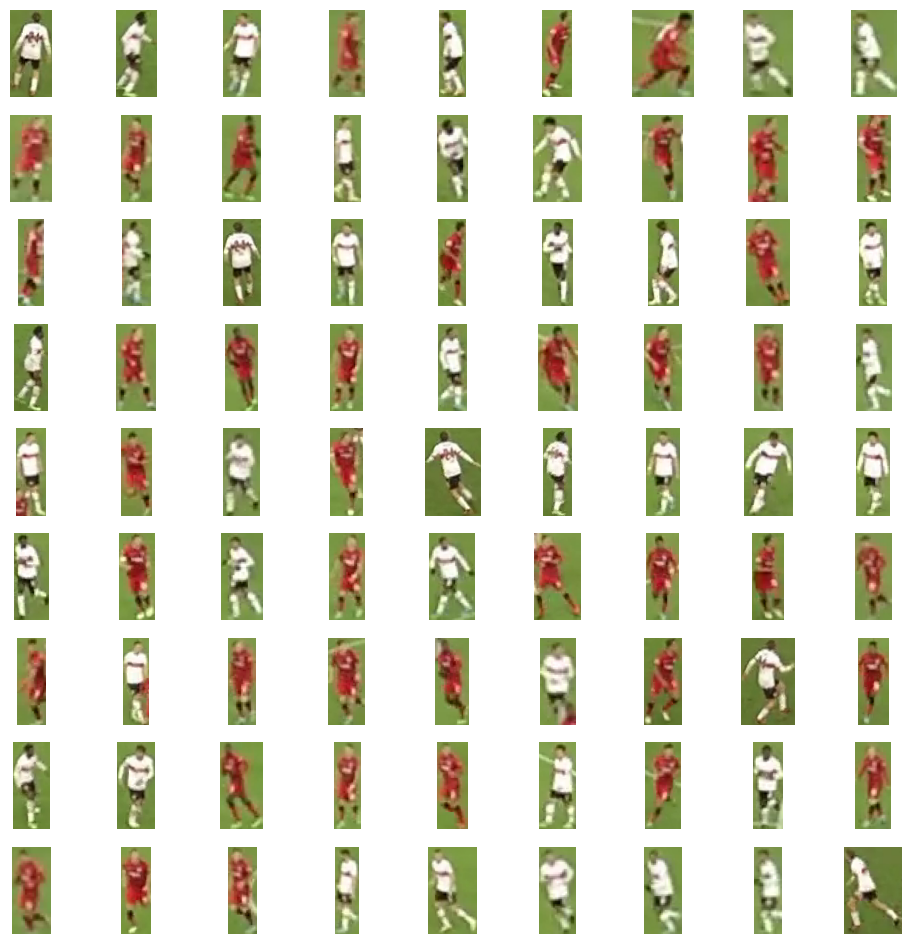

In [7]:
sv.plot_images_grid(crops[:81], grid_size=(9, 9))

In [8]:
import torch
from transformers import AutoProcessor, SiglipVisionModel

SIGLIP_MODEL_PATH = "google/siglip-base-patch16-224"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EMBEDDINGS_MODEL = SiglipVisionModel.from_pretrained(SIGLIP_MODEL_PATH).to(DEVICE)
EMBEDDINGS_PROCESSOR = AutoProcessor.from_pretrained(SIGLIP_MODEL_PATH, use_fast=True)

In [9]:
import numpy as np 
from more_itertools import chunked

BATCH_SIZE = 32


crops = [sv.cv2_to_pillow(crop) for crop in crops]
batches = chunked(crops, BATCH_SIZE)
data = []

with torch.no_grad():
    for batch in tqdm(batches, desc="Extracting embeddings"):
        inputs = EMBEDDINGS_PROCESSOR(images=batch, return_tensors="pt").to(DEVICE)
        outputs = EMBEDDINGS_MODEL(**inputs)
        embeddings = torch.mean(outputs.last_hidden_state, dim=1).cpu().numpy()
        data.append(embeddings)

data = np.concatenate(data)

Extracting embeddings: 0it [00:00, ?it/s]

In [10]:
data.shape

(497, 768)

In [11]:
import umap
from sklearn.cluster import KMeans

REDUCER = umap.UMAP(n_components=3)
CLUSTERING_MODEL = KMeans(n_clusters=2)

In [12]:
projections = REDUCER.fit_transform(data)

In [13]:
projections.shape

(497, 3)

In [14]:
clusters = CLUSTERING_MODEL.fit_predict(projections)

In [15]:
clusters[:10]

array([0, 0, 0, 1, 0, 1, 1, 0, 0, 1], dtype=int32)

In [16]:
team_0 = [crop for crop, cluster in zip(crops, clusters) if cluster == 0]
team_1 = [crop for crop, cluster in zip(crops, clusters) if cluster == 1]

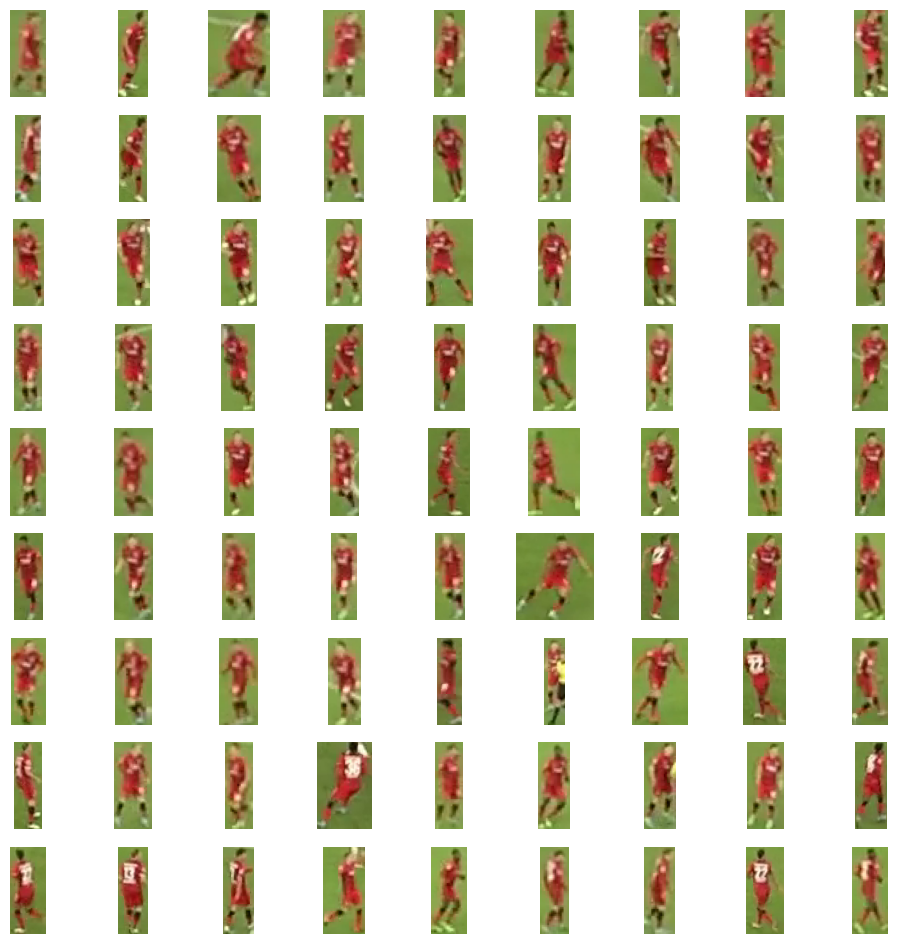

In [19]:
sv.plot_images_grid(team_1[:81], grid_size=(9, 9))